# Model Training Script
Lindsay Fitzpatrick
ljob@umich.edu
12/18/2024

This script reads in CFSR data from 1979 - 2010 and trains machine learning models to target CNBS from L2SWBM across the 5 Great Lakes simultaeously.

In [91]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestClassifier as skRFC
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, RBF, Matern, RationalQuadratic, ExpSineSquared
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor as skRFR
from sklearn.linear_model import LinearRegression as skLR
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import calendar

## User Input

In [63]:
# This is the directory where you cloned the repo
path_to_repo = '/Users/fitzpatrick/Desktop/'

dir = path_to_repo + 'cnbs-predictor-1/data/input/'

## Functions

In [64]:
def seconds_in_month(year, month):
    # Number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    # Convert days to seconds
    return num_days * 24 * 60 * 60

In [65]:
def shift_variables(df, lag=0, lead=0):
    """
    Create the variables columns to include lags (last month values) and lead variables
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the time series data.
    - lag (int): The number of months you want to include lagged variables. Default = 0
    - lead (int): The number of months for the advance variables. Default = 0
    
    Returns:
    - pd.DataFrame: The DataFrame with added variable columns for lags and leading.
    """
    df = df.copy()  # To avoid modifying the original DataFrame

    new_columns = []  # List to store the new lag and lead columns

    # Generate target columns for the lag and lead months
    for column in df.columns:
        for lag_month in range(1, lag + 1):
            new_columns.append(df[column].shift(lag_month).rename(f'{column}_mo-{lag_month}'))
        for lead_month in range(1, lead + 1):
            new_columns.append(df[column].shift(-lead_month).rename(f'{column}_mo{lead_month}'))

    # Concatenate the new columns with the original DataFrame
    df = pd.concat([df] + new_columns, axis=1)

    # Drop rows with any NaN values generated by shifting for the target
    df = df.dropna()

    return df

## Begin Script

In [66]:
## Read in PCP data from CFSR [mm]
pcp_data = pd.read_csv(dir+'training/CFSR_APCP_Basin_Avgs_05.csv',sep=',')

## Read in EVAP data from CFSR [mm]
evap_data = pd.read_csv(dir+'training/CFSR_EVAP_Basin_Avgs_031.csv',sep=',')

## Read in TMP data from CFSR [K]
tmp_data = pd.read_csv(dir+'training/CFSR_TMP_Basin_Avgs_031.csv',sep=',')

Read in L2SWBM in [mm]

https://zenodo.org/records/13883098

In [67]:
sup_evap = pd.read_csv(dir + 'l2swbm/superiorEvap_MonthlyRun.csv')
sup_runoff = pd.read_csv(dir + 'l2swbm/superiorRunoff_MonthlyRun.csv')
sup_precip = pd.read_csv(dir + 'l2swbm/superiorPrecip_MonthlyRun.csv')

eri_evap = pd.read_csv(dir + 'l2swbm/erieEvap_MonthlyRun.csv')
eri_runoff = pd.read_csv(dir + 'l2swbm/erieRunoff_MonthlyRun.csv')
eri_precip = pd.read_csv(dir + 'l2swbm/eriePrecip_MonthlyRun.csv')

ont_evap = pd.read_csv(dir + 'l2swbm/ontarioEvap_MonthlyRun.csv')
ont_runoff = pd.read_csv(dir + 'l2swbm/ontarioRunoff_MonthlyRun.csv')
ont_precip = pd.read_csv(dir + 'l2swbm/ontarioPrecip_MonthlyRun.csv')

mih_evap = pd.read_csv(dir + 'l2swbm/miHuronEvap_MonthlyRun.csv')
mih_runoff = pd.read_csv(dir + 'l2swbm/miHuronRunoff_MonthlyRun.csv')
mih_precip = pd.read_csv(dir + 'l2swbm/miHuronPrecip_MonthlyRun.csv')

Here we prepare the data for training and testing. We set the features 'X' as total over lake
precipitation, total over lake evaporation, and the average air temperature over each lake. The
targets 'y' are RNBS for each lake simultaeously.

In [68]:
# Features
X = pd.DataFrame({
    'sup_pcp_w': pcp_data['sup_lake'],
    'eri_pcp_w': pcp_data['eri_lake'],
    'ont_pcp_w': pcp_data['ont_lake'],
    'mih_pcp_w': pcp_data['mih_lake'],
    'sup_pcp_l': pcp_data['sup_land'],
    'eri_pcp_l': pcp_data['eri_land'],
    'ont_pcp_l': pcp_data['ont_land'],
    'mih_pcp_l': pcp_data['mih_land'],
    'sup_evap_w': evap_data['sup_lake'],
    'eri_evap_w': evap_data['eri_lake'],
    'ont_evap_w': evap_data['ont_lake'],
    'mih_evap_w': evap_data['mih_lake'],
    'sup_evap_l': evap_data['sup_land'],
    'eri_evap_l': evap_data['eri_land'],
    'ont_evap_l': evap_data['ont_land'],
    'mih_evap_l': evap_data['mih_land'],
    'sup_tmp_w': tmp_data['sup_lake'],
    'eri_tmp_w': tmp_data['eri_lake'],
    'ont_tmp_w': tmp_data['ont_lake'],
    'mih_tmp_w': tmp_data['mih_lake'],
    'sup_tmp_l': tmp_data['sup_land'],
    'eri_tmp_l': tmp_data['eri_land'],
    'ont_tmp_l': tmp_data['ont_land'],
    'mih_tmp_l': tmp_data['mih_land']
})

# Set the index by date
X.set_index(pd.to_datetime(pcp_data[['year', 'month']].assign(day=1)), inplace=True)

# Targets are the components of NBS (P, E, R)
targets = pd.DataFrame({
    'sup_evap_t': sup_evap['Median'],
    'sup_pcp_t': sup_precip['Median'],
    'sup_rnoff_t': sup_runoff['Median'],
    'eri_evap_t': eri_evap['Median'],
    'eri_pcp_t': eri_precip['Median'],
    'eri_rnoff_t': eri_runoff['Median'],
    'ont_evap_t': ont_evap['Median'],
    'ont_pcp_t': ont_precip['Median'],
    'ont_rnoff_t': ont_runoff['Median'],
    'mih_evap_t': mih_evap['Median'],
    'mih_pcp_t': mih_precip['Median'],
    'mih_rnoff_t': mih_runoff['Median']
})

# Set the index of the targets
targets.set_index(pd.to_datetime(eri_evap[['Year', 'Month']].assign(day=1)), inplace=True)

In [69]:
shifted_X = shift_variables(X ,lag=0, lead=0)

In [70]:
shifted_targets = shift_variables(targets, lag=0, lead=0)

In [71]:
# Make sure the indices/dates align after the shifts
aligned_y = shifted_targets.loc[shifted_X.index]

print(f'Number of Targets: {aligned_y.shape[1]}')
print(f'Number of Features: {shifted_X.shape[1]}')

Number of Targets: 12
Number of Features: 24


Split the data into training and testing data sets. We could do it as a random 80/20 split
but instead we set split the data set by date ranges. This can easily be adjusted.

In [48]:
# Split dataset by date ranges into training and testing sets
train_start_date = '1979-01-01'
train_end_date = '2004-12-01'
# Testing dataset
val_start_date = '2005-01-01'
val_end_date = '2011-01-01'

X_train = shifted_X[train_start_date:train_end_date]
y_train = aligned_y[train_start_date:train_end_date]
X_test = shifted_X[val_start_date:val_end_date]
y_test = aligned_y[val_start_date:val_end_date]

It is best practice to standardize the data from 0-1 before training

In [72]:
# Standardize the data
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.fit_transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.fit_transform(y_test)

Training

Below we train different models using the same data and calculate the r squared values on the 
test data to compare performance.

In [ ]:
# Testing Different Kernels
# Basic kernel using ConstantKernel: r2 = 0.8259
#kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))

# Matt's optimal kernel: 
# # MVP r2 = 0.8159
# # Geo mask r2: 0.8176
# # 
kernel = 1.0 * Matern(nu=1.5) * RationalQuadratic()

# Test to add a seasonality component: r2 = 0.8279
#period = 3.0  # Period of the season
#kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + ExpSineSquared(length_scale=1.0, periodicity=period, periodicity_bounds=(1e-2, 1e2))

#kernel = 1.0 * ExpSineSquared(periodicity=12)

#kernel = 1.0 * RBF() + 1.0 * Matern(nu=2.5) + 1.0 * RationalQuadratic()

# Set up the model
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.1, n_restarts_optimizer=10, random_state=42)

# Fit the model
gpr.fit(X_train_scaled, y_train_scaled)

# Save the trained model
joblib.dump(gpr, dir +'GP_trained_model.joblib')
joblib.dump(x_scaler, dir + 'x_scaler.joblib')
joblib.dump(y_scaler, dir + 'y_scaler.joblib')

# Predictions
y_pred_GP, sigma = gpr.predict(X_test_scaled, return_std=True)

# Calculate R2 and MSE
mse_gp = mean_squared_error(y_test_scaled, y_pred_GP)
r2_gp = r2_score(y_test_scaled, y_pred_GP)

print(f"Random Forest R^2 score: {r2_gp}")
print(f"Mean Squared Error: {mse_gp}")

Random Forest R^2 score: 0.8420223920088205
Mean Squared Error: 0.15797760799117966


In [77]:
## Linear Regression ##

# Initialize Linear Regression
lr_model = skLR()

# Train the model
trained_LR = lr_model.fit(X_train_scaled, y_train_scaled)

# Save the trained model
joblib.dump(trained_LR, dir + 'LR_trained_model.joblib')

# Predict on the test set
y_pred_LR = trained_LR.predict(X_test_scaled)

# Calculate R2 and MSE
mse_lr = mean_squared_error(y_test_scaled, y_pred_LR)
r2_lr = r2_score(y_test_scaled, y_pred_LR)

print(f"Linear Regression R^2 score: {r2_lr:.4f}")
print(f"Mean Squared Error: {mse_lr}")

Linear Regression R^2 score: 0.7991
Mean Squared Error: 0.20093166239053736


In [78]:
## Random Forest Regressor Model:

# Initialize RandomForestRegressor
rfr_model = skRFR(random_state=42)

# Train the model
trained_RFR = rfr_model.fit(X_train_scaled, y_train_scaled)

# Save the trained model
joblib.dump(trained_RFR, dir + 'RF_trained_model.joblib')

# Predict on the test set
y_pred_rfr = trained_RFR.predict(X_test_scaled)

# Calculate Mean Squared Error
mse_rf = mean_squared_error(y_test_scaled, y_pred_rfr)
r2_rf = r2_score(y_test_scaled, y_pred_rfr)

print(f"Linear Regression R^2 score: {r2_rf:.4f}")
print(f"Mean Squared Error: {mse_rf}")

Linear Regression R^2 score: 0.7507
Mean Squared Error: 0.24933708800769683


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1738 - mae: 0.8824 - val_loss: 0.7414 - val_mae: 0.7091
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7207 - mae: 0.6803 - val_loss: 0.5193 - val_mae: 0.5806
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5086 - mae: 0.5565 - val_loss: 0.3979 - val_mae: 0.4937
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4081 - mae: 0.4905 - val_loss: 0.3379 - val_mae: 0.4458
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3257 - mae: 0.4343 - val_loss: 0.3108 - val_mae: 0.4197
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2962 - mae: 0.4066 - val_loss: 0.2922 - val_mae: 0.4059
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2749 - mae: 0.3864 - val_loss: 0.2766 - val_mae: 0.3921
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2618 - mae: 0.3741 - val_loss: 0.2818 - val_mae: 0.3942
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2429 - mae: 0.3657 - val_loss

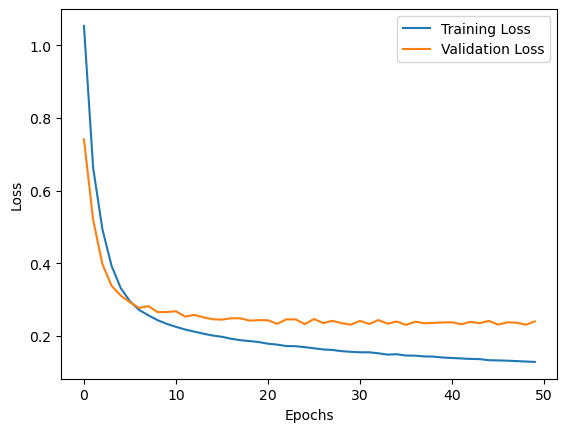

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Linear Regression R^2 score: 0.8051
Mean Squared Error: 0.19486304659932985


In [98]:
## Neural Network ##

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1])
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae']) # Using mean squared error (mse) as the loss function


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Fit the model to the training data
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)#, callbacks=[early_stopping])

# Plotting the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained model
joblib.dump(model,dir + 'NN_trained_model.joblib')

# Predict on the test set
y_pred_nn = model.predict(X_test_scaled)

# Calculate Mean Squared Error
mse_nn = mean_squared_error(y_test_scaled, y_pred_nn)
r2_nn = r2_score(y_test_scaled, y_pred_nn)

print(f"Linear Regression R^2 score: {r2_nn:.4f}")
print(f"Mean Squared Error: {mse_nn}")